# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

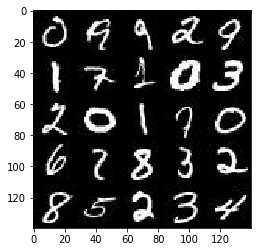

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

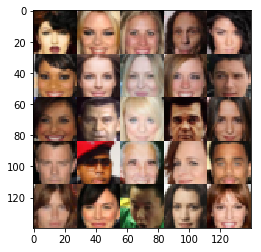

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    # create input tensor for the real image of dimension WxHXC
    input_real = tf.placeholder(tf.float32, 
                                [None, image_width, image_height, image_channels],
                                name = 'input_real')
    
    # create input tensor for the fake image for z_dim dimension
    input_fake = tf.placeholder(tf.float32, 
                                [None, z_dim],
                                name = 'input_z')
    
    # learning rate placeholder
    learn_rate = tf.placeholder(tf.float32, 
                                None,
                                name = 'learning_rate')

    return input_real, input_fake, learn_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

tests.test_model_inputs(model_inputs)

Tests Passed


In [7]:
def relu(node, alpha):
    '''
    Perform leaky rectified linear unit on the node
    :param node: Tensor to pass through linear unit
    :param alpha: scale of rectification of values < 0
    : return rectified linear tensor
    '''
    return tf.maximum(node * alpha, node)


def rn_initializer():
    '''
    Random normal initializer
    '''
    return tf.random_normal_initializer(mean = 0.0, stddev = 0.01)


def xev_init():
    '''
    Xavier initializer
    '''
    return tf.contrib.layers.xavier_initializer(uniform = True)


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [50]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # build the discriminator network
    # input image --> convolution -> convolution -> convolution -> sigmoid -> true/false
    # limit the scope of all trainable variables with 'discriminator'    
    with tf.variable_scope('discriminator', reuse = reuse):
        
        # convolution layer parameters
        padding     = 'same'
        conv_stride = 2
        filter_size = 32
        kernel_size = 5
        alpha       = 0.1
        drop_rate   = 0.7
        
        # Input layer convolution [28*28*Depth --> 14*14*32]
        conv1  = tf.layers.conv2d(images, filter_size, kernel_size, 
                                 strides = conv_stride, padding = padding,
                                 kernel_initializer = xev_init())
        conv1 = relu(conv1, alpha)
        
        # Second convolution layer [14*14*32 --> 7*7*64]
        conv2 = tf.layers.conv2d(conv1, filter_size * 2, kernel_size, 
                                 strides = conv_stride, padding = padding,
                                 kernel_initializer = xev_init())
        
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = relu(conv2, alpha)
        conv2 = tf.layers.dropout(conv2, rate = drop_rate)
        
        # 3rd convolution layer [7*7*64 --> 4*4*128]
        conv3 = tf.layers.conv2d(conv2, filter_size * 4, kernel_size, 
                                 strides= conv_stride, padding= padding,
                                 kernel_initializer = xev_init())
        
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = relu(conv3, alpha)
        conv3 = tf.layers.dropout(conv3, rate = drop_rate)
        
        # tranform from 3-D to 1-D tensor
        #[batch_size, height, width, depth] = conv3.get_shape().as_list()
        #flat_layer = tf.reshape(conv3, [-1, height * width * depth])
        flat_layer = tf.contrib.layers.flatten(conv3)
                
        # fully connected layer
        #weight = tf.get_variable('weight', [height * width * depth, 1], 
        #                         initializer = xev_init())
            
        #bias   = tf.get_variable('bias', [1],
        #                         initializer = tf.constant_initializer(0))
                       
        #logits = tf.matmul(flat_layer, weight) + bias
        #out    = tf.sigmoid(logits)
        
        logits = tf.layers.dense(flat_layer, 1,
                                 kernel_initializer = xev_init())
        
        output  = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [51]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # build the discriminator network
    # sample --> conneted_layer --> convolution_t -> convolution_t -> convolution_t -> tanh -> output
    # limit the scope of all trainable variables with 'generator'    
    with tf.variable_scope('generator', reuse = (is_train != True)):
        
        # convolution layer parameters
        padding     = 'same'
        conv_stride = 2
        filter_size = 128
        kernel_size = 5
        alpha       = 0.1
        
        # First layer: fully connected layer 7*7*512
        width   = 7
        height  = 7
        depth   = 512
        n_units = width * height * depth 
        shape   = z.get_shape().as_list()
        
        #weight = tf.get_variable('weight', [shape[-1], n_units], 
        #                          initializer = tf.random_normal_initializer(mean = 0.0, stddev = 0.1))
        #bias   = tf.get_variable('bias', [n_units], 
        #                         initializer = tf.constant_initializer(0))
        #first_layer     = tf.matmul(z, weight) + bias
        
        first_layer = tf.layers.dense(z, n_units)
        
        # reshape 1-D tensor to 3-D tensor for convolution: 7*7*512
        first_layer = tf.reshape(first_layer, [-1, width, height, depth])
        first_layer = tf.layers.batch_normalization(first_layer, training = is_train)
        first_layer = tf.maximum(alpha * first_layer, first_layer)
    
        # Second layer: transposed convolution layer to transform the resolution 
        # from 7*7*512-> 7*7*128
        conv1 = tf.layers.conv2d_transpose(first_layer, filter_size, kernel_size, 
                                           strides = 1, padding = padding,
                                           kernel_initializer = xev_init())
              
        conv1 = tf.layers.batch_normalization(conv1, training= is_train)
        conv1 = relu(conv1, alpha)
        
        # Third layer: transposed convolution layer to transform the resolution 
        # from 7*7*128 to 14*14*64
        conv2 = tf.layers.conv2d_transpose(conv1, int(filter_size/2), kernel_size, 
                                           strides = conv_stride, padding = padding,
                                           kernel_initializer = xev_init())
        
        conv2 = tf.layers.batch_normalization(conv2, training= is_train)
        conv2 = relu(conv2, alpha)
                    
        # Fourth layer: transposed convolution layer to transform the resolution
        # from 14*14*64 to 14*14*32
        conv3 = tf.layers.conv2d_transpose(conv2, int(filter_size/4), kernel_size, 
                                           strides = 1, padding = padding,
                                           kernel_initializer = xev_init())
        conv3 = tf.layers.batch_normalization(conv3, training= is_train)
        conv3 = relu(conv3, alpha)
                
        # Fifth layer: transposed convolution layer to transform the resolution
        # from 14*14*32 to 28*28*Channels
        conv4 = tf.layers.conv2d_transpose(conv3, out_channel_dim, kernel_size, 
                                           strides = conv_stride, padding = padding,
                                           kernel_initializer = xev_init())
        # Pass it through tanh
        output = tf.tanh(conv4)
               
        return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [52]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # label smoothing
    smooth = 0.1
    
    # Generator network output
    g_model = generator(input_z, out_channel_dim, is_train = True)
    
    # Disriminator network output for real image
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    
    # Discriminator network output for fake image
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    # Calculate network loss
    real_labels = tf.ones_like(d_logits_real) * (1 - smooth)
    zero_labels = tf.zeros_like(d_logits_fake) 
    
    # get loss for real and fake image classification from discriminator
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, 
                                                                         labels = real_labels))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, 
                                                                         labels = zero_labels))
    
    # add real and fake image losses to find the total loss for discriminator
    d_loss = d_loss_real + d_loss_fake
    
    # get the loss for generator for fake image
    g_labels = tf.ones_like(d_logits_fake)
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, 
                                                                    labels = g_labels))
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [53]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # separate generator and discriminator variables
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if 'generator' in var.name]
    d_vars = [var for var in t_vars if 'discriminator' in var.name]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        
        # get optimizers
        d_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)
        d_train_opt = d_optimizer.minimize(d_loss, var_list = d_vars)
        
        g_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)
        g_train_opt = g_optimizer.minimize(g_loss, var_list = g_vars)
        
        return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [54]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [55]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    show_n_images = 20
    
    # get input placeholders
    _, width, height, channels      = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    
    # get network losses and optimizers
    d_loss, g_loss           = model_loss(input_real, input_z, channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
            
    train_steps = 0
    print_steps = 50
    show_steps  = 100
    
    # start training
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            train_steps = 0
            for batch_images in get_batches(batch_size):
                
                train_steps += 1
                
                # rescale image range from [-0.5, 0.5] to [-1, 1]
                in_image = batch_images *2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run discriminator and generator optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real : in_image, 
                                                     input_z    : batch_z,
                                                     learn_rate : learning_rate
                                                    })
                
                _ = sess.run(g_train_opt, feed_dict={input_z    : batch_z,
                                                     input_real : in_image,
                                                     learn_rate : learning_rate,
                                                    })
                
                _ = sess.run(g_train_opt, feed_dict={input_z    : batch_z,
                                                     input_real : in_image,
                                                     learn_rate : learning_rate,
                                                    })
                
                if train_steps % print_steps == 0:
                    # print losses at this point
                    train_loss_d = d_loss.eval({input_real: in_image, 
                                                input_z   : batch_z})
                    
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}. ".format(epoch_i+1, train_steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    if(train_steps % show_steps) == 0:
                        show_generator_output(sess, show_n_images, input_z, channels, data_image_mode)
    
    print('Trained model.')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/50.  Discriminator Loss: 2.3673... Generator Loss: 0.2367
Epoch 1/100.  Discriminator Loss: 1.8884... Generator Loss: 0.8628


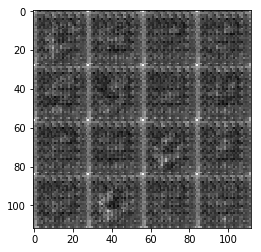

Epoch 1/150.  Discriminator Loss: 1.9948... Generator Loss: 0.2435
Epoch 1/200.  Discriminator Loss: 1.5147... Generator Loss: 0.7743


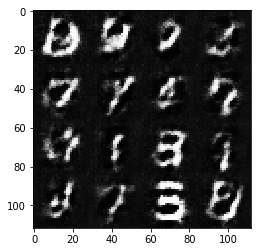

Epoch 1/250.  Discriminator Loss: 1.6459... Generator Loss: 0.5886
Epoch 1/300.  Discriminator Loss: 1.6731... Generator Loss: 0.4617


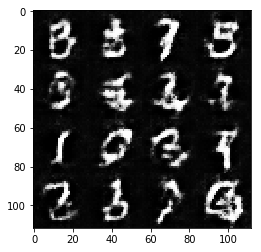

Epoch 1/350.  Discriminator Loss: 1.5344... Generator Loss: 0.5744
Epoch 1/400.  Discriminator Loss: 1.6700... Generator Loss: 0.4429


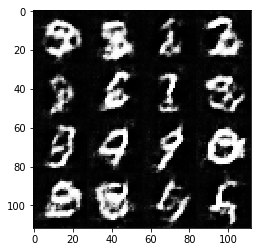

Epoch 1/450.  Discriminator Loss: 1.5968... Generator Loss: 0.6415
Epoch 1/500.  Discriminator Loss: 1.8805... Generator Loss: 0.3238


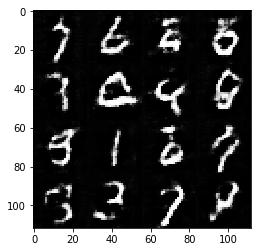

Epoch 1/550.  Discriminator Loss: 1.7855... Generator Loss: 0.3026
Epoch 1/600.  Discriminator Loss: 1.6314... Generator Loss: 0.6109


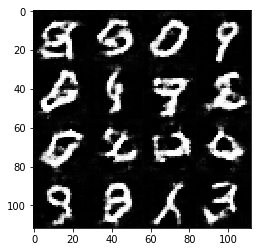

Epoch 1/650.  Discriminator Loss: 1.6663... Generator Loss: 0.4437
Epoch 1/700.  Discriminator Loss: 1.6167... Generator Loss: 0.4777


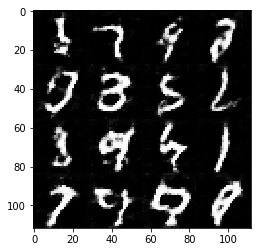

Epoch 1/750.  Discriminator Loss: 1.5727... Generator Loss: 0.6097
Epoch 1/800.  Discriminator Loss: 1.7442... Generator Loss: 0.3820


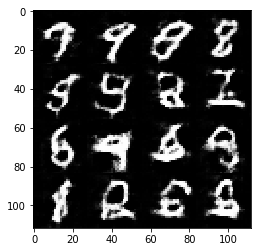

Epoch 1/850.  Discriminator Loss: 1.5835... Generator Loss: 0.7659
Epoch 1/900.  Discriminator Loss: 1.6261... Generator Loss: 0.4238


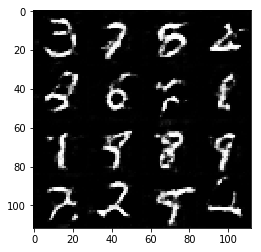

Epoch 1/950.  Discriminator Loss: 1.3727... Generator Loss: 0.6616
Epoch 1/1000.  Discriminator Loss: 1.5390... Generator Loss: 0.5539


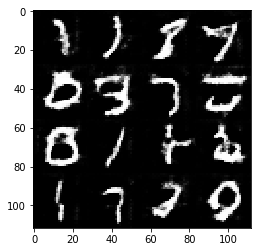

Epoch 1/1050.  Discriminator Loss: 1.4660... Generator Loss: 0.8036
Epoch 1/1100.  Discriminator Loss: 1.6402... Generator Loss: 0.6252


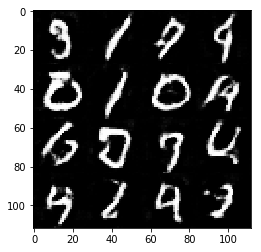

Epoch 1/1150.  Discriminator Loss: 1.5281... Generator Loss: 0.5394
Epoch 1/1200.  Discriminator Loss: 1.3508... Generator Loss: 0.8984


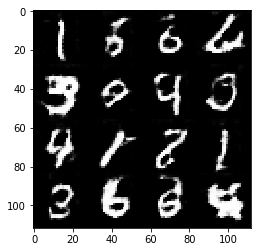

Epoch 1/1250.  Discriminator Loss: 1.5424... Generator Loss: 0.5771
Epoch 1/1300.  Discriminator Loss: 1.6539... Generator Loss: 0.6648


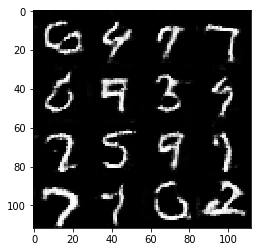

Epoch 1/1350.  Discriminator Loss: 1.5052... Generator Loss: 0.4936
Epoch 1/1400.  Discriminator Loss: 1.5801... Generator Loss: 0.4780


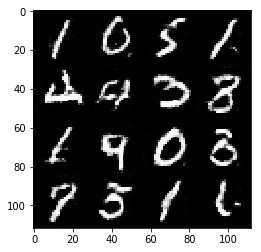

Epoch 1/1450.  Discriminator Loss: 1.5025... Generator Loss: 0.5091
Epoch 1/1500.  Discriminator Loss: 1.5397... Generator Loss: 0.5705


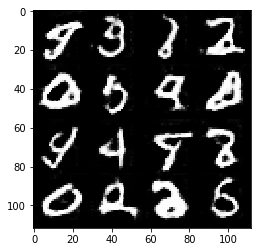

Epoch 1/1550.  Discriminator Loss: 1.6611... Generator Loss: 0.3997
Epoch 1/1600.  Discriminator Loss: 1.4657... Generator Loss: 0.5389


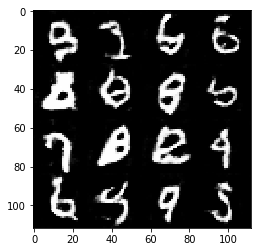

Epoch 1/1650.  Discriminator Loss: 1.4223... Generator Loss: 0.5504
Epoch 1/1700.  Discriminator Loss: 1.6191... Generator Loss: 0.5089


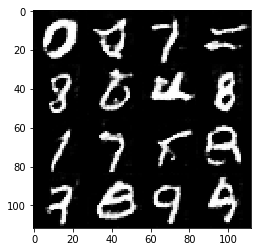

Epoch 1/1750.  Discriminator Loss: 1.5823... Generator Loss: 0.4365
Epoch 1/1800.  Discriminator Loss: 1.4335... Generator Loss: 0.6027


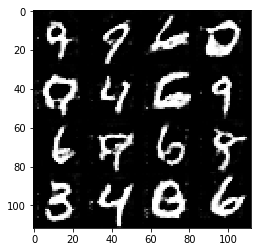

Epoch 1/1850.  Discriminator Loss: 1.3674... Generator Loss: 0.6885
Epoch 2/50.  Discriminator Loss: 1.4431... Generator Loss: 0.9038
Epoch 2/100.  Discriminator Loss: 1.8698... Generator Loss: 0.2841


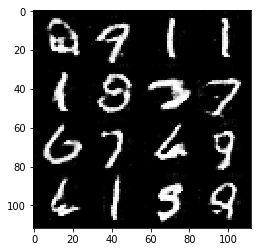

Epoch 2/150.  Discriminator Loss: 1.5111... Generator Loss: 0.4903
Epoch 2/200.  Discriminator Loss: 1.6897... Generator Loss: 1.0596


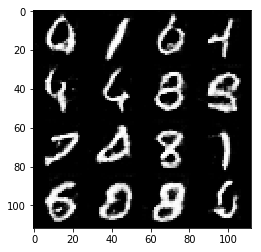

Epoch 2/250.  Discriminator Loss: 1.4933... Generator Loss: 0.5342
Epoch 2/300.  Discriminator Loss: 1.5052... Generator Loss: 0.4620


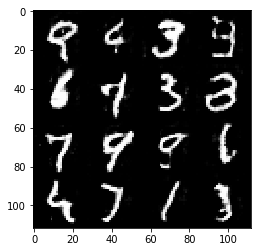

Epoch 2/350.  Discriminator Loss: 1.3145... Generator Loss: 0.8788
Epoch 2/400.  Discriminator Loss: 1.7770... Generator Loss: 0.3353


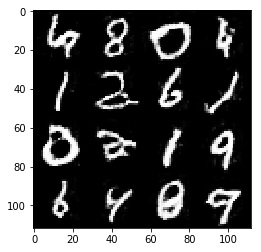

Epoch 2/450.  Discriminator Loss: 1.3814... Generator Loss: 0.5224
Epoch 2/500.  Discriminator Loss: 1.5058... Generator Loss: 0.5582


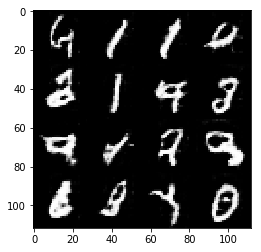

Epoch 2/550.  Discriminator Loss: 1.2945... Generator Loss: 0.8703
Epoch 2/600.  Discriminator Loss: 1.4745... Generator Loss: 0.4865


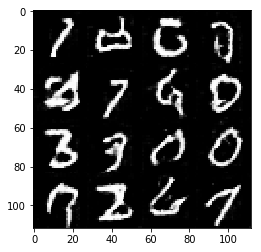

Epoch 2/650.  Discriminator Loss: 1.3989... Generator Loss: 0.5869
Epoch 2/700.  Discriminator Loss: 1.3736... Generator Loss: 0.5967


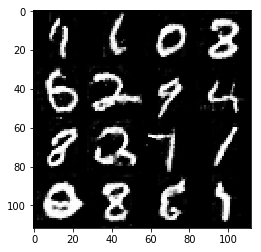

Epoch 2/750.  Discriminator Loss: 1.2726... Generator Loss: 0.7459
Epoch 2/800.  Discriminator Loss: 1.7517... Generator Loss: 0.3336


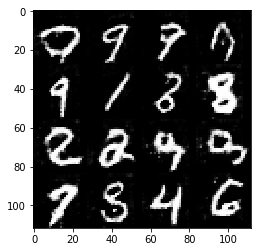

Epoch 2/850.  Discriminator Loss: 1.7150... Generator Loss: 0.3463
Epoch 2/900.  Discriminator Loss: 1.6080... Generator Loss: 0.3832


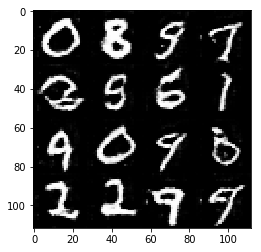

Epoch 2/950.  Discriminator Loss: 1.3214... Generator Loss: 0.6508
Epoch 2/1000.  Discriminator Loss: 1.3676... Generator Loss: 0.6299


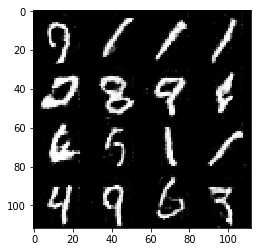

Epoch 2/1050.  Discriminator Loss: 1.4912... Generator Loss: 0.8139
Epoch 2/1100.  Discriminator Loss: 1.5024... Generator Loss: 0.4685


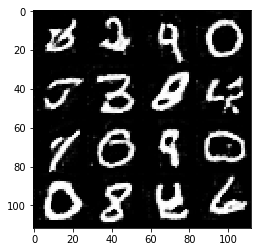

Epoch 2/1150.  Discriminator Loss: 1.4244... Generator Loss: 0.6636
Epoch 2/1200.  Discriminator Loss: 1.4215... Generator Loss: 0.7365


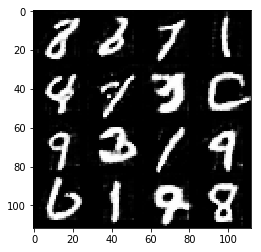

Epoch 2/1250.  Discriminator Loss: 1.3710... Generator Loss: 0.5635
Epoch 2/1300.  Discriminator Loss: 1.3702... Generator Loss: 0.8623


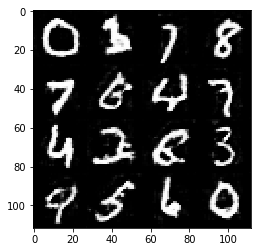

Epoch 2/1350.  Discriminator Loss: 1.8648... Generator Loss: 0.2894
Epoch 2/1400.  Discriminator Loss: 1.4358... Generator Loss: 0.4573


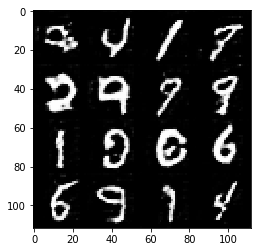

Epoch 2/1450.  Discriminator Loss: 1.2963... Generator Loss: 0.7692
Epoch 2/1500.  Discriminator Loss: 1.9773... Generator Loss: 1.7576


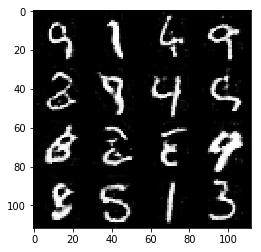

Epoch 2/1550.  Discriminator Loss: 1.2346... Generator Loss: 0.6655
Epoch 2/1600.  Discriminator Loss: 1.3663... Generator Loss: 0.6347


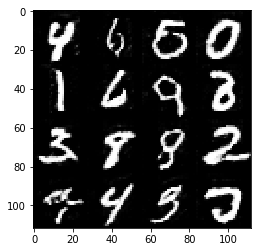

Epoch 2/1650.  Discriminator Loss: 1.2183... Generator Loss: 0.9378
Epoch 2/1700.  Discriminator Loss: 1.7107... Generator Loss: 0.4381


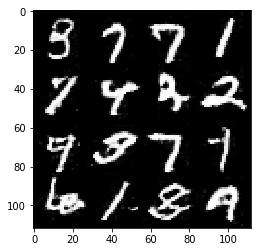

Epoch 2/1750.  Discriminator Loss: 1.5666... Generator Loss: 0.4108
Epoch 2/1800.  Discriminator Loss: 1.2259... Generator Loss: 0.7138


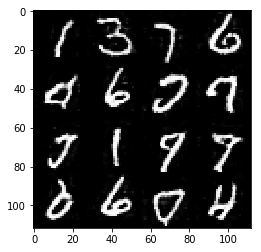

Epoch 2/1850.  Discriminator Loss: 1.7275... Generator Loss: 0.7378
Trained model.


In [56]:
batch_size    = 32
z_dim         = 128
learning_rate = 0.0003
beta1         = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs =2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/50.  Discriminator Loss: 1.8065... Generator Loss: 0.6099
Epoch 1/100.  Discriminator Loss: 1.9689... Generator Loss: 0.5437


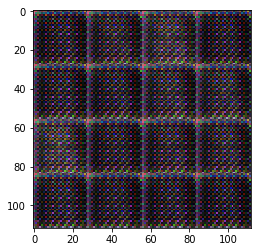

Epoch 1/150.  Discriminator Loss: 1.5766... Generator Loss: 0.7047
Epoch 1/200.  Discriminator Loss: 1.7866... Generator Loss: 0.6043


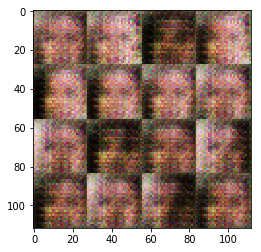

Epoch 1/250.  Discriminator Loss: 1.6818... Generator Loss: 0.5873
Epoch 1/300.  Discriminator Loss: 1.5633... Generator Loss: 0.6955


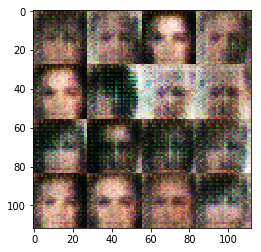

Epoch 1/350.  Discriminator Loss: 1.5243... Generator Loss: 0.6813
Epoch 1/400.  Discriminator Loss: 1.5122... Generator Loss: 0.7304


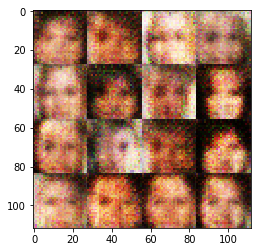

Epoch 1/450.  Discriminator Loss: 1.4937... Generator Loss: 0.7268
Epoch 1/500.  Discriminator Loss: 1.4772... Generator Loss: 0.7146


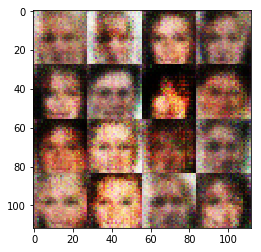

Epoch 1/550.  Discriminator Loss: 1.4649... Generator Loss: 0.7166
Epoch 1/600.  Discriminator Loss: 1.4531... Generator Loss: 0.7548


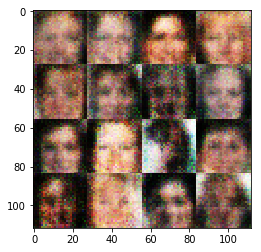

Epoch 1/650.  Discriminator Loss: 1.4644... Generator Loss: 0.7049
Epoch 1/700.  Discriminator Loss: 1.4562... Generator Loss: 0.7379


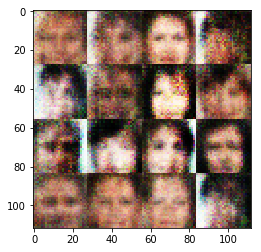

Epoch 1/750.  Discriminator Loss: 1.4399... Generator Loss: 0.7509
Epoch 1/800.  Discriminator Loss: 1.4406... Generator Loss: 0.7569


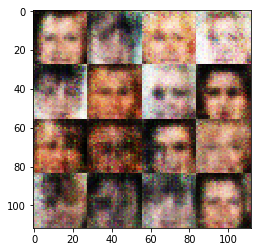

Epoch 1/850.  Discriminator Loss: 1.4285... Generator Loss: 0.7689
Epoch 1/900.  Discriminator Loss: 1.4199... Generator Loss: 0.7465


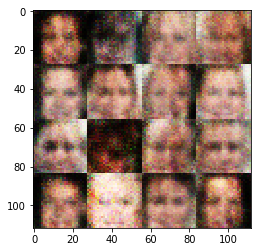

Epoch 1/950.  Discriminator Loss: 1.4248... Generator Loss: 0.7560
Epoch 1/1000.  Discriminator Loss: 1.4444... Generator Loss: 0.7305


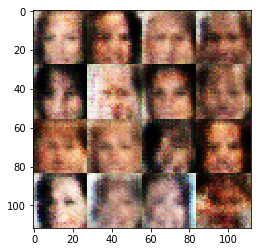

Epoch 1/1050.  Discriminator Loss: 1.4006... Generator Loss: 0.7822
Epoch 1/1100.  Discriminator Loss: 1.4149... Generator Loss: 0.7459


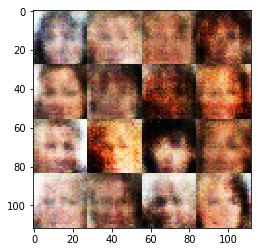

Epoch 1/1150.  Discriminator Loss: 1.4186... Generator Loss: 0.7636
Epoch 1/1200.  Discriminator Loss: 1.4254... Generator Loss: 0.7536


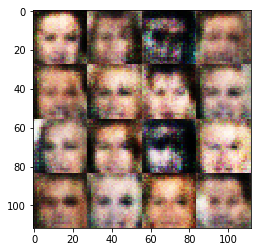

Epoch 1/1250.  Discriminator Loss: 1.4111... Generator Loss: 0.7672
Epoch 1/1300.  Discriminator Loss: 1.4107... Generator Loss: 0.7433


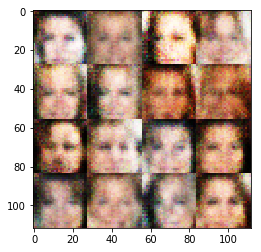

Epoch 1/1350.  Discriminator Loss: 1.4216... Generator Loss: 0.7667
Epoch 1/1400.  Discriminator Loss: 1.4000... Generator Loss: 0.7696


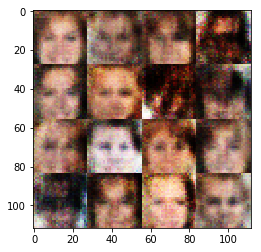

Epoch 1/1450.  Discriminator Loss: 1.4116... Generator Loss: 0.7708
Epoch 1/1500.  Discriminator Loss: 1.4125... Generator Loss: 0.7665


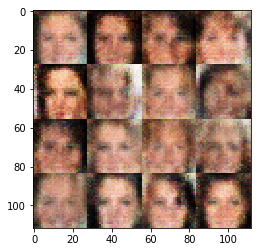

Epoch 1/1550.  Discriminator Loss: 1.4057... Generator Loss: 0.8006
Trained model.


In [60]:
batch_size    = 128
z_dim         = 128
learning_rate = 0.0003
beta1         = 0.33


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.